In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

from time import perf_counter

from utilities import drawSketch, computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap, get_pca_components_for_var, plot_pca_components, df_to_heatmap, get_reconstruction_error, get_max_along_df_axis


# Define settings

In [66]:
# Import shared settings
from settings import random_state, n_jobs, test_size, pRows, pCols, pColNames, pScale, nSamples, names, accuracyMin, accuracyMax, max_iter
# Override settings
#...

In [94]:
# Set n_components to be used during grid searching (was set here based on PCA)
n_components = [1, 2, 9, 34, 98, 156, 206, 295, 478, 666, 784]
# n_components = [1, 2, 9, 34, 98]

In [83]:
# Used for plot names
casename = "quickdraw_ica"
# scoreText = "Score (Classification Accuracy)"

# Load and curate data

In [68]:
dataDict = getDrawData(names, nSamples=nSamples)
data = dataDict['df']
nameDict = dataDict['nameDict']

print("")
print("Loaded the following named categories, with classNumbers shown")
print(nameDict)

# Scale pixel data
for col in pColNames:
    data[col] = data[col] / pScale

Loading 2500 samples for baseball from ./data/full_numpy_bitmap_baseball.npy
Loading 2500 samples for basketball from ./data/full_numpy_bitmap_basketball.npy

Loaded the following named categories, with classNumbers shown
{'baseball': 0, 'basketball': 1}


In [69]:
# Create X, y, X_test, y_test using just the features we care about...

X_full = data.loc[:, pColNames].values
print(f'X_full.shape = {X_full.shape}')
y_full = data.loc[:, 'classNumber'].values
print(f'y_full.shape = {y_full.shape}')

X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=test_size, 
                                      random_state=random_state, stratify=y_full)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(y == 1).sum() / float(len(y))} (should be 0.5)')


print('')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
print(f'Ratio of y_test=1 to y_test=0 for Test data: {(y_test == 1).sum() / float(len(y_test))} (should be 0.5)')

X_full.shape = (5000, 784)
y_full.shape = (5000,)

X.shape = (4000, 784)
y.shape = (4000,)
Ratio of y=1 to y=0 for Training data: 0.5 (should be 0.5)

X_test.shape = (1000, 784)
y_test.shape = (1000,)
Ratio of y_test=1 to y_test=0 for Test data: 0.5 (should be 0.5)


# Apply ICA

## Run MLP using results of ICA through Grid Search

In [95]:
pipe = Pipeline([('scaler', StandardScaler()),
                  ('ica', FastICA(random_state)),
                  ('mlp', MLPClassifier(max_iter=max_iter, random_state=random_state))])

#                  [0.5, 0.75, 0.9, 0.95, 0.99]
hidden_layer_sizes = [(2, ), (4, ), (6, ), (10, )]
param_grid = {'ica__n_components': n_components,
             'mlp__hidden_layer_sizes': hidden_layer_sizes,
             }
gs = GridSearchCV(pipe, param_grid=param_grid, verbose=10, cv=5, return_train_score=True, 
                  n_jobs=n_jobs)

In [96]:
gs.fit(X, y)
joblib.dump(gs, casename + "_gs.pkl")

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 32

['quickdraw_ica_gs.pkl']

In [106]:
gs.best_params_

{'ica__n_components': 34, 'mlp__hidden_layer_sizes': (10,)}

In [101]:
results = pd.DataFrame(gs.cv_results_)
results.to_csv(casename + "_results.csv")

In [102]:
results.loc[:, ["param_mlp__hidden_layer_sizes", "param_ica__n_components", "mean_test_score", "mean_train_score"]]

,param_mlp__hidden_layer_sizes,param_ica__n_components,mean_test_score,mean_train_score
0,"(2,)",1,0.50000,0.500000
1,"(4,)",1,0.50000,0.500000
2,"(6,)",1,0.57725,0.575438
3,"(10,)",1,0.57900,0.578688
4,"(2,)",2,0.50000,0.500000
5,"(4,)",2,0.55100,0.555688
6,"(6,)",2,0.58300,0.578563
7,"(10,)",2,0.57950,0.583375
8,"(2,)",9,0.50000,0.500000
9,"(4,)",9,0.80550,0.803750


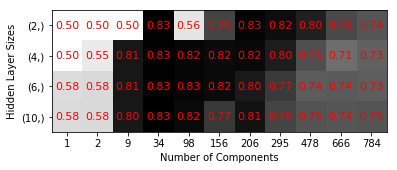

In [103]:
x_variable = "param_ica__n_components"
y_variable = "param_mlp__hidden_layer_sizes"
z_variable = "mean_test_score"

df_to_heatmap(results, x_variable, y_variable, z_variable, fontsize=11, xlabel='Number of Components', ylabel='Hidden Layer Sizes')

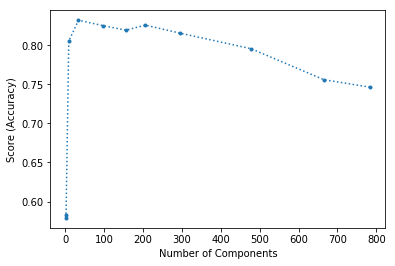

In [104]:
x_variable = "param_ica__n_components"
z_variable = "mean_test_score"
best_scores = get_max_along_df_axis(results, z_variable, x_variable)
fig, ax = plt.subplots()
ax.plot(best_scores[:, 0], best_scores[:, 1], '.:', label='MLP fit on ICA')
ax.set_xlabel("Number of Components")
ax.set_ylabel("Score (Accuracy)")
plt.show()

In [ ]:
# TODO: Rank the features by kurtosis and take the n best of them to make another accuracy curve

## Build a pipeline using all components in order to play with Kurtosis

In [82]:
pipe_all_components = Pipeline([('scaler', StandardScaler()),
                  ('ica', FastICA(random_state=random_state)),])

In [78]:
t_start = perf_counter()
pipe_all_components.fit(X)
print(f"Time to complete = {perf_counter() - t_start: .1f}s")

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Time to complete =  78.7s


In [75]:
pipe_all_components.named_steps['ica'].components_.shape

(1, 784)

In [76]:
X.shape

(4000, 784)

In [ ]:
gs.fit(X, y)

In [ ]:
results = pd.DataFrame(gs.cv_results_)

In [54]:
n_components = 2
ica = FastICA(n_components=2)

In [55]:
X_ica = ica.fit_transform(X_scaled)

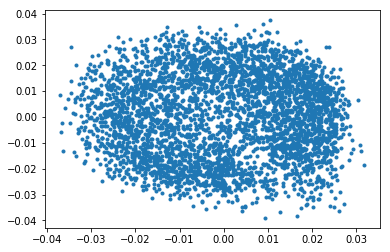

In [56]:
plt.plot(X_ica[:, 0], X_ica[:, 1], '.')

In [57]:
pd.DataFrame(X_ica).kurt(axis=0)

0   -1.080125
1   -0.959447
dtype: float64

In [58]:
components = np.array([1, 2, 3, 5, 10, 20, 30, 50, 100, 150, 200, 300, 400, 500])
# components = np.array([2, 3, 5, 10, 20, 34, 50, 100, 150, 200, 214, 250, 300, 308, 400, 493, 500, 600, 700, 28**2])
results = {}
for nc in components:
    print(nc)
    ica = FastICA(n_components=nc, random_state=random_state, max_iter=max_iter)
    X_ica = ica.fit_transform(X_scaled)
    kurtosis = pd.DataFrame(X_ica).kurt(axis=0)
    kurtosis_abs_mean = kurtosis.abs().mean()
    results[nc] = {
        'kurt_mean': kurtosis_abs_mean,
        'reconstruction_error': reconstruction_error(X_scaled, ica),
    }

1
2
3
5
10
20


C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


30


C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


50
100
150
200
300
400
500


In [59]:
df = pd.DataFrame(results).T

In [ ]:
df_pca = pd.read_csv('quickdraw_pca.csv')

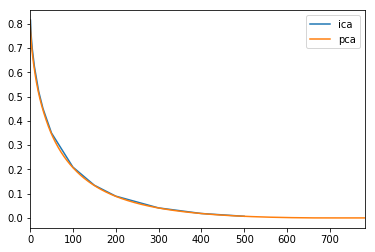

In [60]:
fig, ax = plt.subplots()

df.plot(y='reconstruction_error', label='ica', ax=ax)
df_pca.plot(y='reconstruction_error', label='pca', ax=ax)

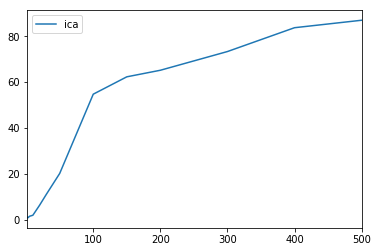

In [61]:
fig, ax = plt.subplots()

df.plot(y='kurt_mean', label='ica', ax=ax)
# df_pca.plot(y='reconstruction_error', label='pca', ax=ax)

In [30]:
ica.components_.shape

(5, 784)

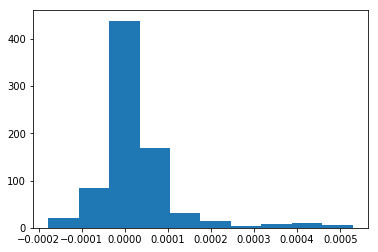

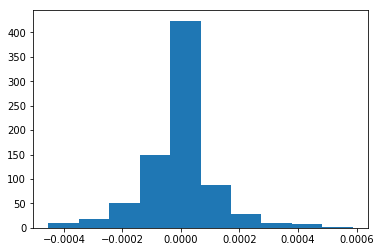

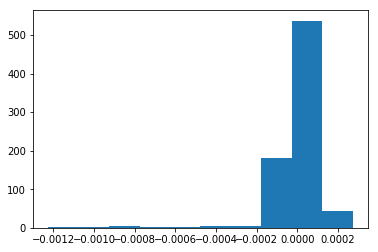

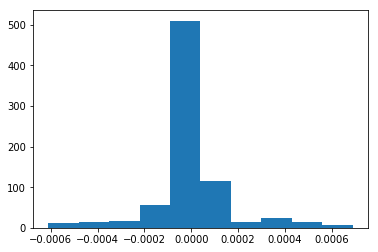

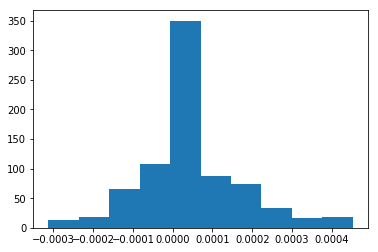

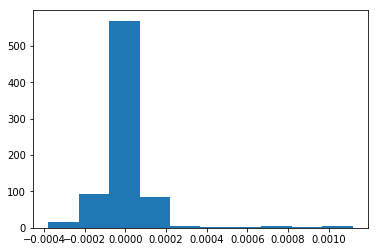

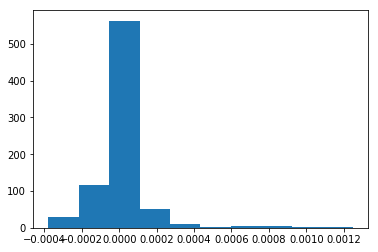

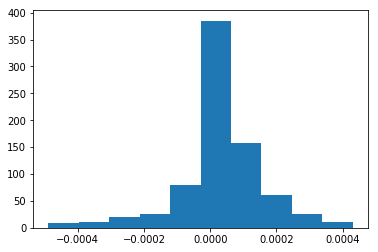

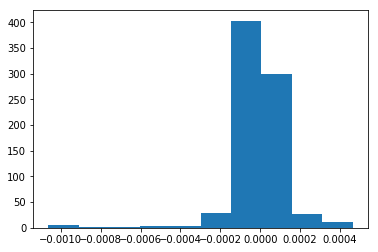

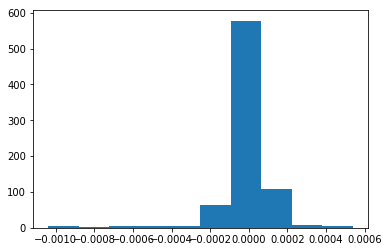

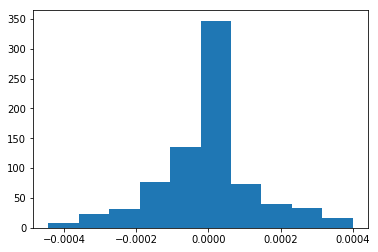

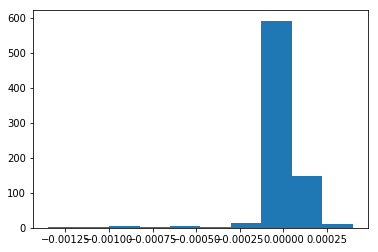

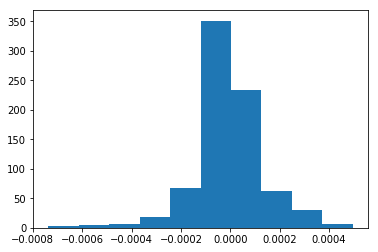

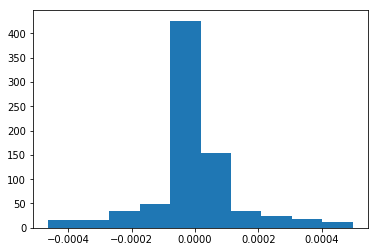

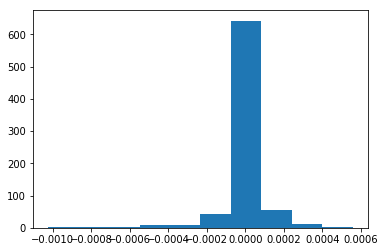

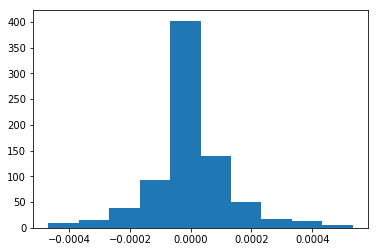

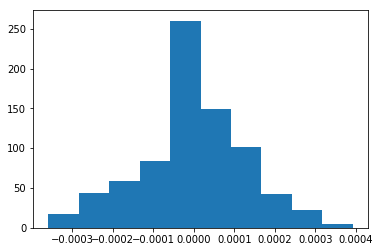

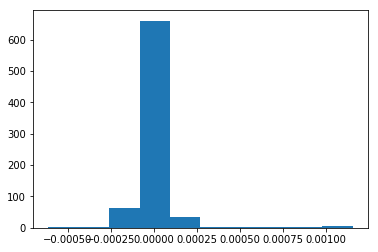

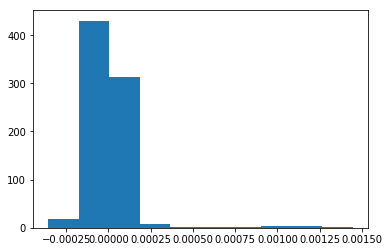

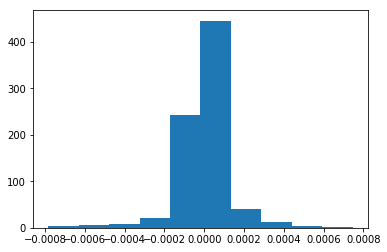

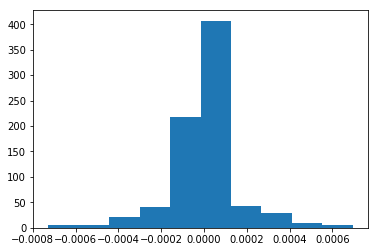

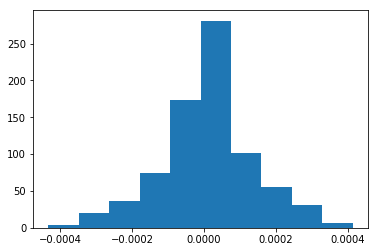

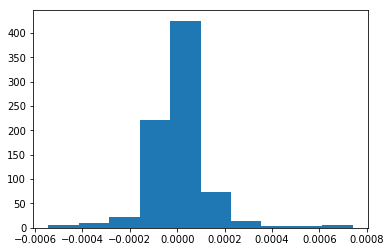

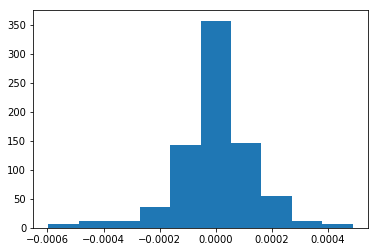

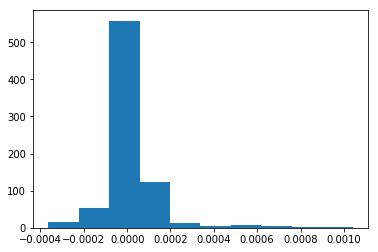

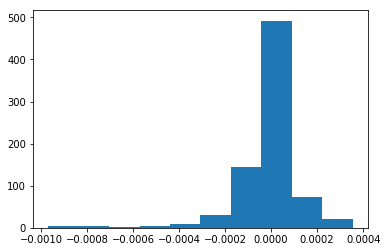

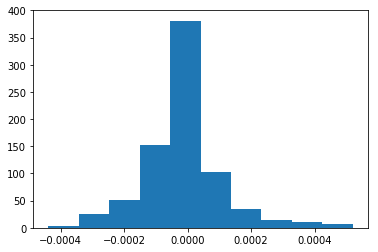

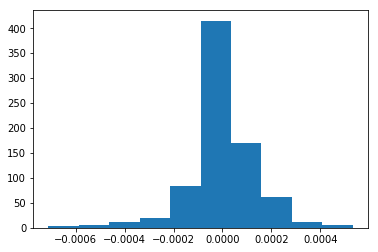

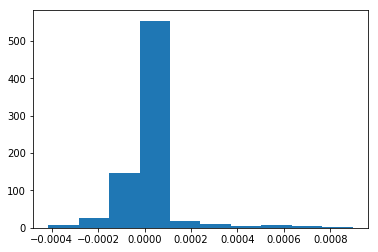

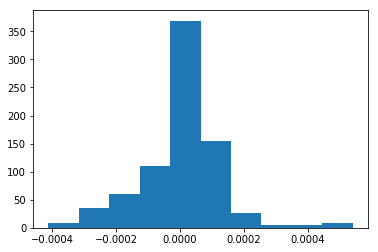

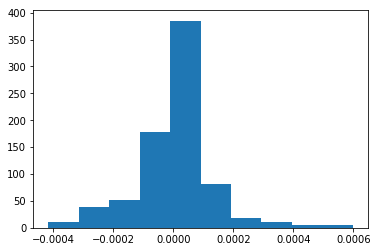

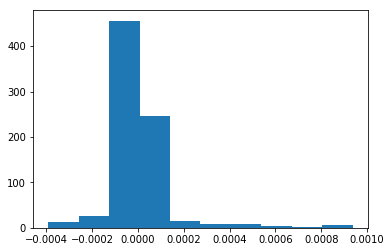

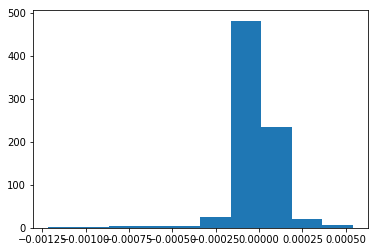

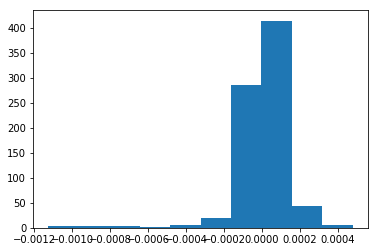

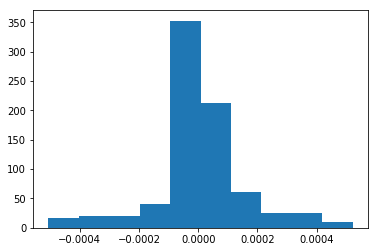

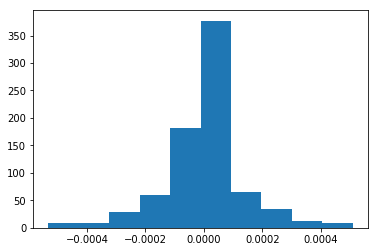

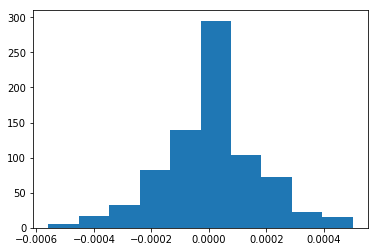

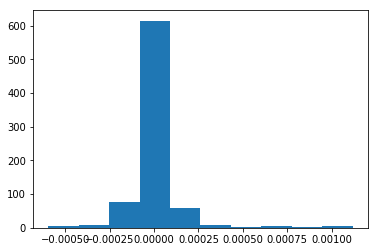

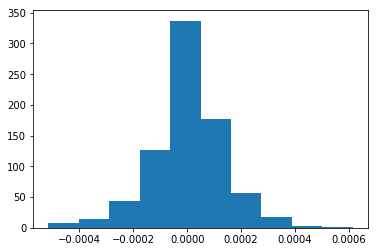

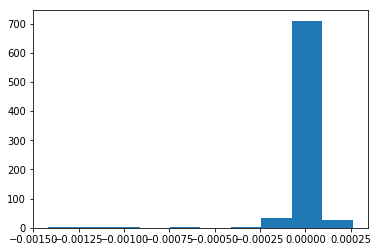

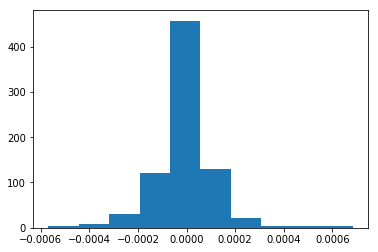

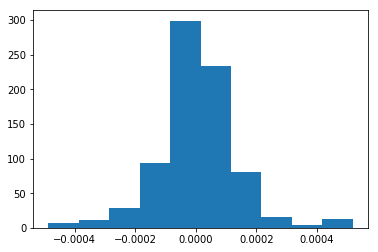

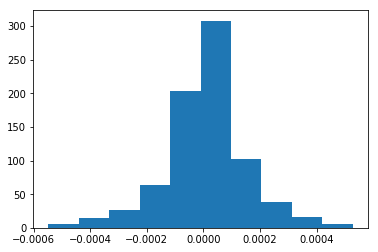

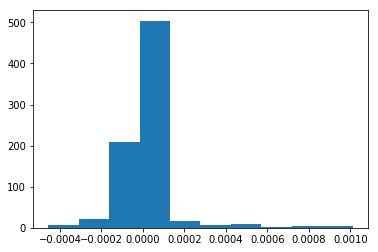

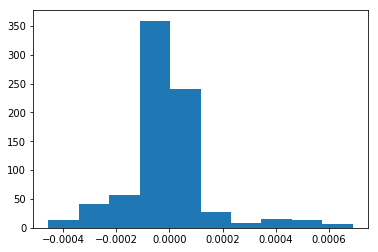

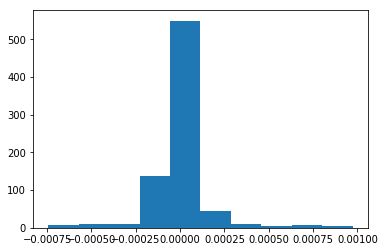

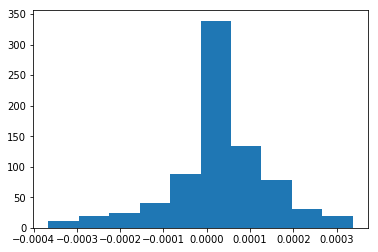

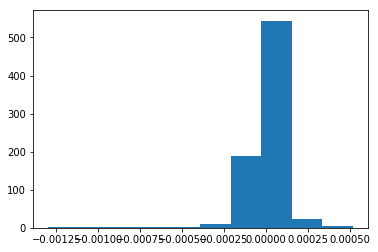

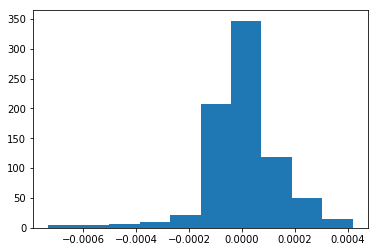

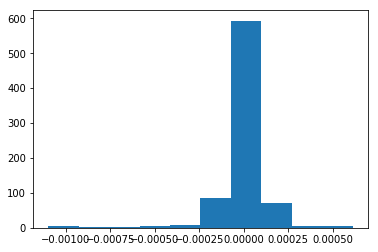

In [36]:
for i in range(len(ica.components_)):
    plt.hist(ica.components_[i, :])
    plt.show()

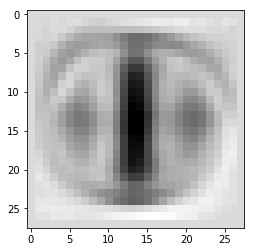

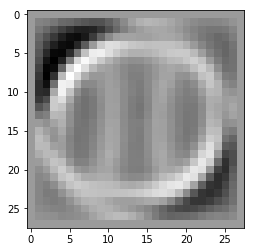

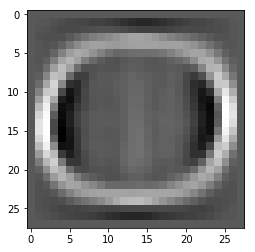

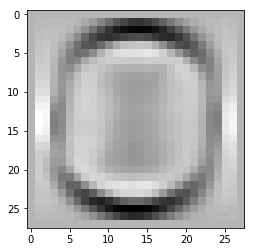

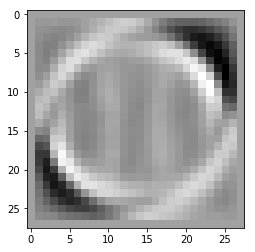

In [32]:
for i in range(len(ica.components_)):
    drawSketch(ica.components_[i, :])

C:\Users\Scribs\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


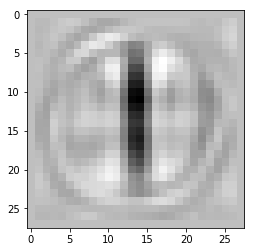

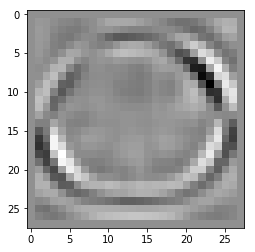

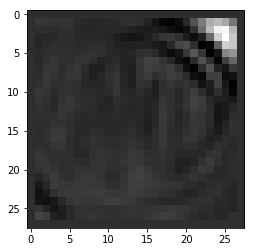

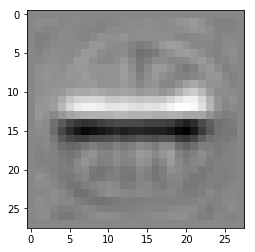

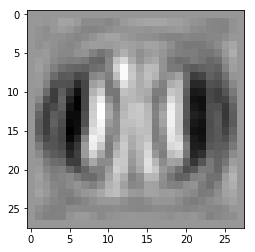

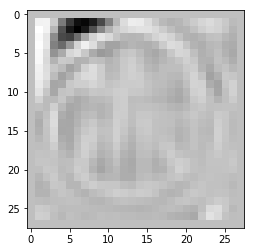

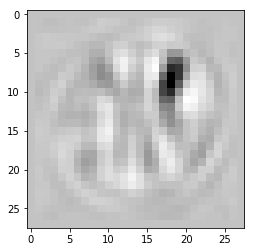

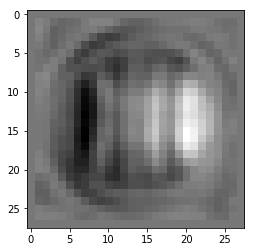

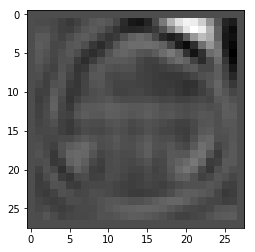

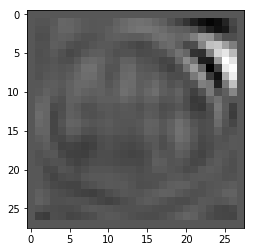

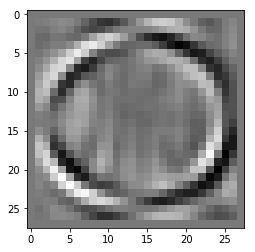

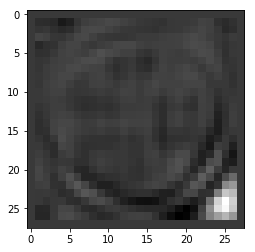

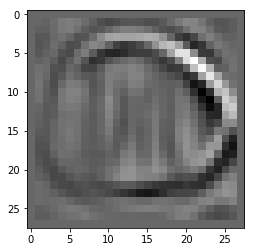

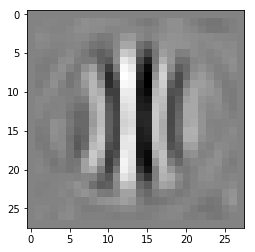

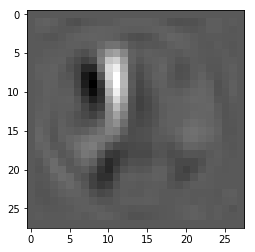

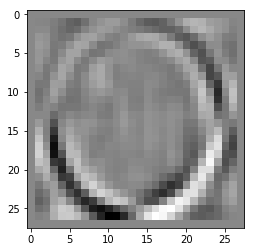

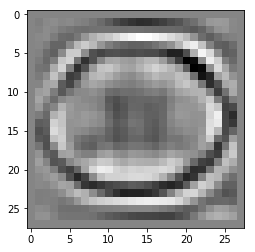

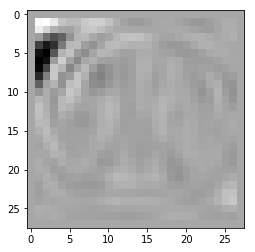

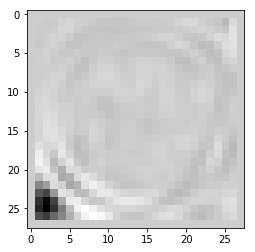

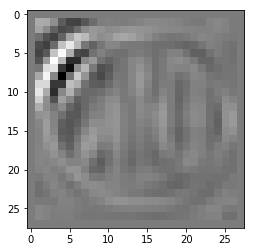

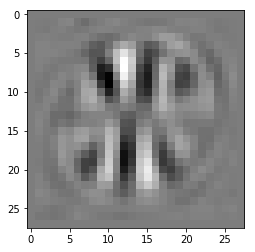

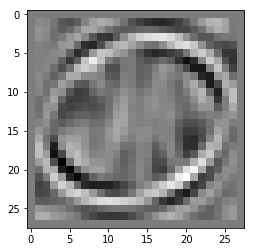

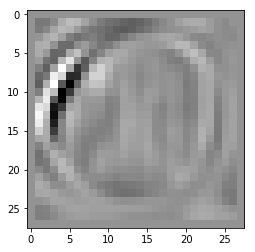

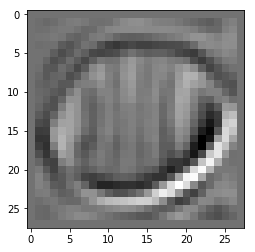

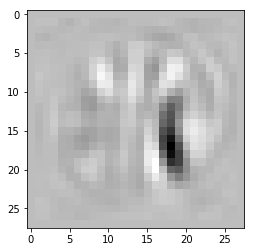

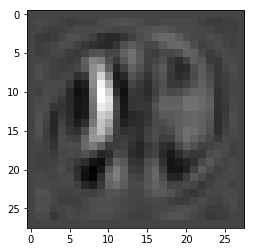

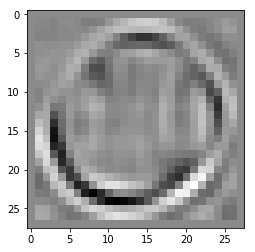

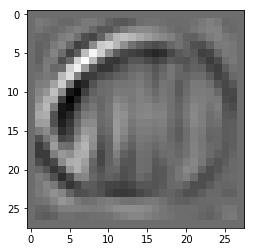

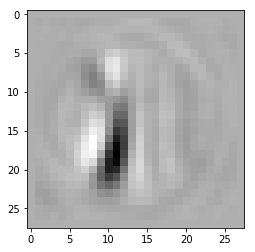

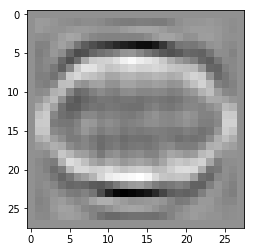

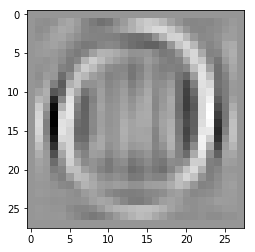

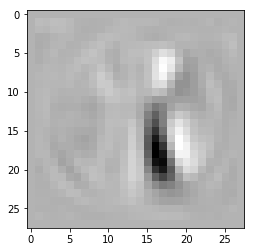

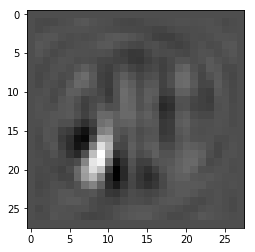

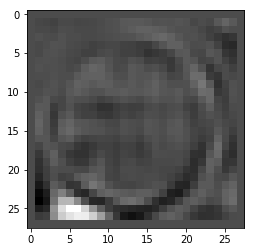

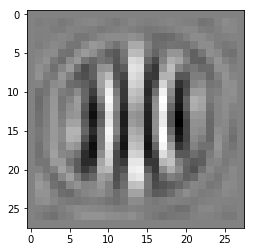

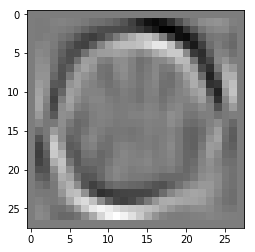

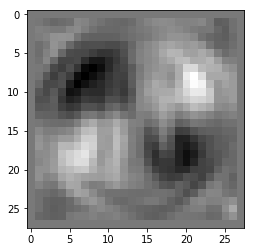

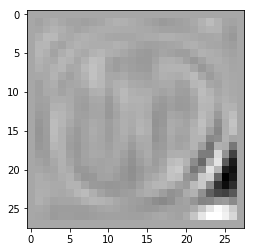

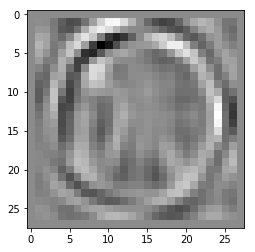

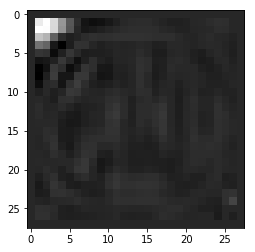

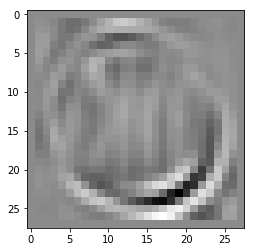

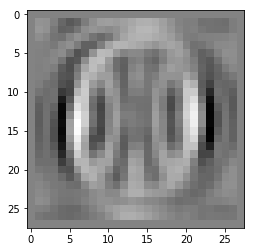

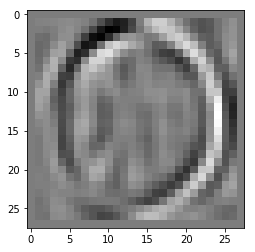

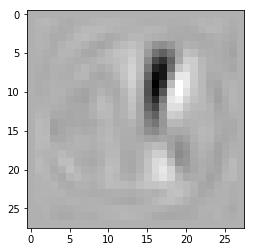

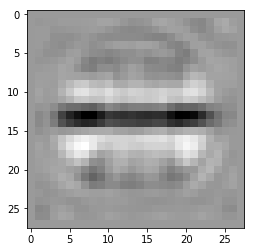

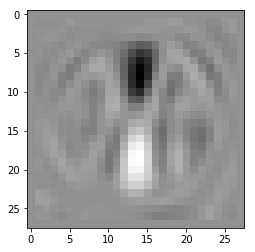

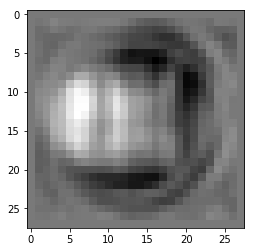

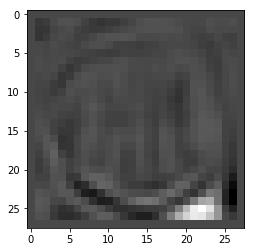

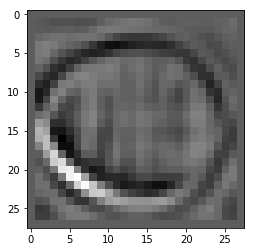

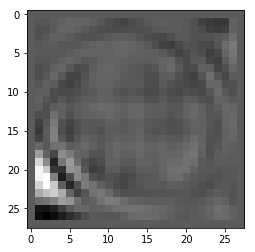

In [34]:
for i in range(len(ica.components_)):
    drawSketch(ica.components_[i, :])

In [ ]:
kurtosis = {}
for nc in comp

ValueError: cannot reshape array of size 2 into shape (28,28)

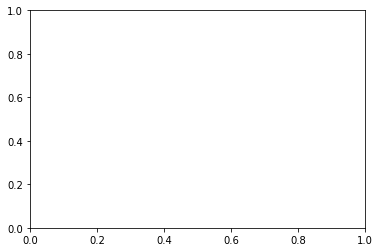

In [16]:
drawSketch(X_ica[0], )

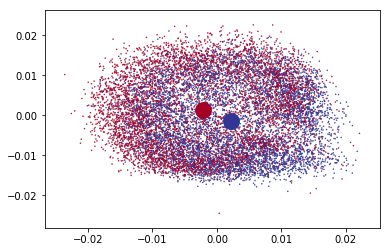

In [15]:
comp1 = 0
cmap = plt.cm.get_cmap('RdYlBu', 2)
for comp2 in [1]:
    plt.scatter(X_ica[:, comp1], X_ica[:, comp2], s=1, marker='.', c=y, cmap=cmap)
    # plt.show()

    for label in np.unique(y):
        mask = y == label
        plt.scatter(X_ica[mask, comp1].mean(), X_ica[mask, comp2].mean(), s=1000, marker='.', c=cmap(np.array((label,))))
    plt.show()

# Apply PCA

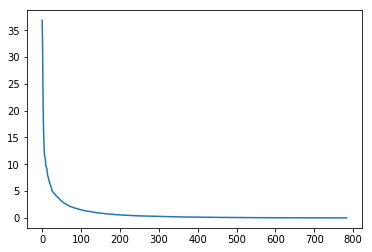

In [299]:
plt.plot(pca.explained_variance_)

In [121]:
pca = PCA(random_state=random_state)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [159]:
X_pca = pca.transform(X)
X_test_pca = pca.transform(X_test)

In [126]:
def get_pca_compoennts_for_var(pca, var):
    """
    Return the minimum number of PCA components that exceeds the requested variance explained
    """
    #    cumulative variance > target variance ==> array of False False ... False True ... True True 
    #    (FF...FT...TT).argmax() gives index of first True
    return (pca.explained_variance_ratio_.cumsum() > var).argmax()

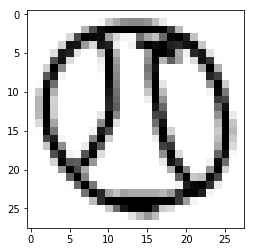

In [125]:
np.array((False, False, True, True)).argmax()

2

In [141]:
pca_explained_variance_ratio_cumsum[key_variances_i-1]

TypeError: unsupported operand type(s) for -: 'list' and 'int'

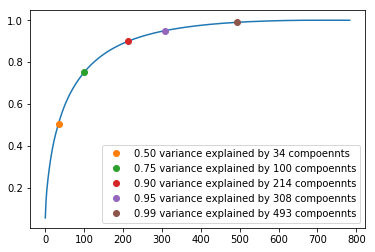

In [149]:
key_variances = [0.5, 0.75, 0.9, 0.95, 0.99]
key_variances_i = [get_pca_compoennts_for_var(pca, x) for x in key_variances]
pca_explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(pca_explained_variance_ratio_cumsum)
for i, var in zip(key_variances_i, key_variances):
    plt.plot(i, pca_explained_variance_ratio_cumsum[i], 'o', label=f'{var:.2f} variance explained by {i} compoennts')
plt.legend()

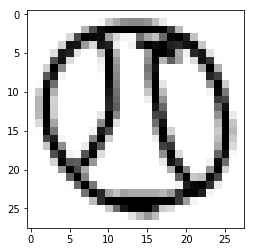

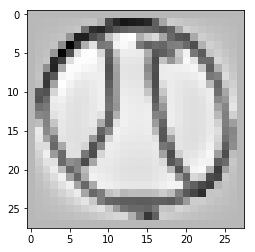

In [158]:
drawSketch(X[0, :])
drawSketch(X_scaled[0, :])

In [270]:
def plot_pca_components(x, coefficients=None, mean=0, components=None,
                        imshape=(8, 8), n_components=8, fontsize=12, plot_step=1,
                        show_mean=True):
    """
    Modified from: https://jakevdp.github.io/PythonDataScienceHandbook/06.00-figure-code.html#Digits-PCA-Components
    """
    if isinstance(plot_step, int):
        to_plot = [x for x in range(n_components) if x % plot_step == 0]
    else:
        to_plot = plot_step
        
    print(to_plot)    
    if coefficients is None:
        coefficients = x
        
    if components is None:
        components = np.eye(len(coefficients), len(x))
        
    mean = np.zeros_like(x) + mean
        
    n_plots = len(to_plot)
    fig = plt.figure(figsize=(1.2 * (5 + n_plots), 1.2 * 2))
    g = plt.GridSpec(2, 4 + bool(show_mean) + n_plots, hspace=0.3)

    def show(i, j, x, title=None):
        ax = fig.add_subplot(g[i, j], xticks=[], yticks=[])
        ax.imshow(x.reshape(imshape), interpolation='nearest')
        if title:
            ax.set_title(title, fontsize=fontsize)

    show(slice(2), slice(2), x, "True")
    
    approx = mean.copy()
    
    counter = 2
    if show_mean:
        show(0, 2, np.zeros_like(x) + mean, r'$\mu$')
        show(1, 2, approx, r'$Var_{Explained}=$')
        counter += 1

        
    evrc = np.cumsum(pca.explained_variance_ratio_)
    i_plot = 0
    for i in range(n_components):
        approx = approx + coefficients[i] * components[i]
        if i in to_plot:
            show(0, i_plot + counter, components[i], f'$\leq c_{{{i}}}$')
            show(1, i_plot + counter, approx,
                 f'{evrc[i]:.2f}')
#                  f'${coefficients[i]:.2f} \cdot c_{{{i}}}$')
#             if show_mean or i > 0:
#                 plt.gca().text(0, 1.05, '$+$', ha='right', va='bottom',
#                                transform=plt.gca().transAxes, fontsize=fontsize)
            i_plot += 1
            
    show(slice(2), slice(-2, None), approx, "Approx")
    return fig


[0, 34, 100, 214, 308, 493]


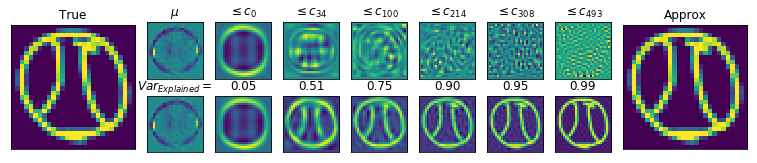

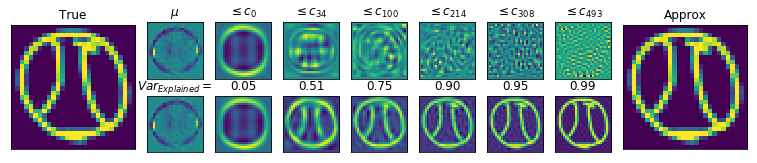

In [271]:
# Plotting scaled
plot_pca_components(scaler.inverse_transform(X_scaled[0, :]), coefficients=X_pca[0, :], mean=pca.mean_, components=pca.components_,
                    imshape=(28, 28), n_components=784, fontsize=12, plot_step=[0] + key_variances_i)

In [242]:
# Plotting scaled
plot_pca_components(X_scaled[0, :], coefficients=X_pca[0, :], mean=pca.mean_, components=pca.components_,
                    imshape=(28, 28), n_components=28**2, fontsize=12, plot_step=50)

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750]


TypeError: unsupported operand type(s) for /: 'int' and 'list'

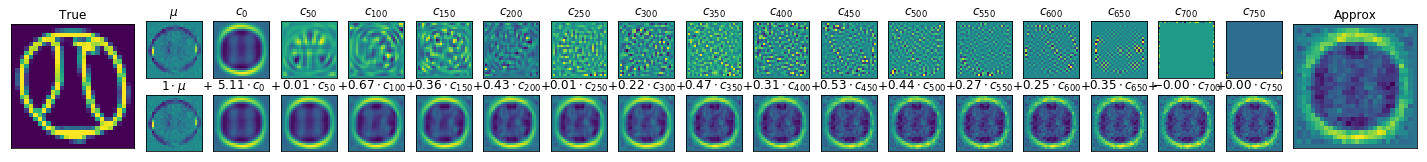

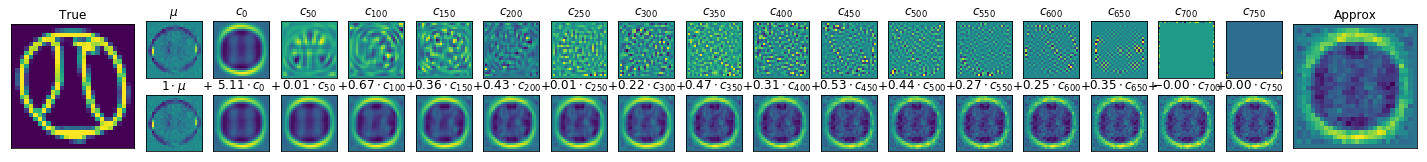

In [239]:
# Plotting transform
plot_pca_components(scaler.inverse_transform(X_scaled[0, :]), coefficients=scaler.inverse_transform(X_pca[0, :]), mean=pca.mean_, components=pca.components_,
                    imshape=(28, 28), n_components=28**2, fontsize=12, plot_step=50)

# Fit with MLP Classifier

In [295]:
clf = MLPClassifier(hidden_layer_sizes=(6, ), activation='logistic', max_iter=max_iter, random_state=random_state)
clf_pca = MLPClassifier(hidden_layer_sizes=(6, ), activation='logistic', max_iter=max_iter, random_state=random_state, verbose=True)

In [287]:
t_start = perf_counter()
clf.fit(X_scaled, y)
print(f"Fit time = {perf_counter() - t_start}s")

Fit time = 46.20330139999896


In [288]:
t_start = perf_counter()
score = clf.score(X_test_scaled, y_test)
print(f'Scored {score:.3f} in {perf_counter() - t_start:.3f}s')

Scored 0.817 in 0.008s


In [296]:
t_start = perf_counter()
clf_pca.fit(X_pca, y)
print(f"Fit time = {perf_counter() - t_start}")

Iteration 1, loss = 0.67559834
Iteration 2, loss = 0.64267933
Iteration 3, loss = 0.61162706
Iteration 4, loss = 0.58302320
Iteration 5, loss = 0.55861749
Iteration 6, loss = 0.53878231
Iteration 7, loss = 0.52294693
Iteration 8, loss = 0.51068160
Iteration 9, loss = 0.50101637
Iteration 10, loss = 0.49320163
Iteration 11, loss = 0.48714273
Iteration 12, loss = 0.48197387
Iteration 13, loss = 0.47774552
Iteration 14, loss = 0.47411400
Iteration 15, loss = 0.47094592
Iteration 16, loss = 0.46814804
Iteration 17, loss = 0.46545874
Iteration 18, loss = 0.46327722
Iteration 19, loss = 0.46114422
Iteration 20, loss = 0.45919557
Iteration 21, loss = 0.45698648
Iteration 22, loss = 0.45522280
Iteration 23, loss = 0.45299458
Iteration 24, loss = 0.45131212
Iteration 25, loss = 0.44968895
Iteration 26, loss = 0.44808922
Iteration 27, loss = 0.44608418
Iteration 28, loss = 0.44424217
Iteration 29, loss = 0.44242522
Iteration 30, loss = 0.43983938
Iteration 31, loss = 0.43777053
Iteration 32, los

Iteration 253, loss = 0.20790126
Iteration 254, loss = 0.20690189
Iteration 255, loss = 0.20637301
Iteration 256, loss = 0.20578680
Iteration 257, loss = 0.20610889
Iteration 258, loss = 0.20501496
Iteration 259, loss = 0.20473763
Iteration 260, loss = 0.20433978
Iteration 261, loss = 0.20364091
Iteration 262, loss = 0.20309377
Iteration 263, loss = 0.20287313
Iteration 264, loss = 0.20239115
Iteration 265, loss = 0.20183869
Iteration 266, loss = 0.20139320
Iteration 267, loss = 0.20106787
Iteration 268, loss = 0.20053424
Iteration 269, loss = 0.20006395
Iteration 270, loss = 0.19964714
Iteration 271, loss = 0.19929562
Iteration 272, loss = 0.19901828
Iteration 273, loss = 0.19861517
Iteration 274, loss = 0.19781385
Iteration 275, loss = 0.19767636
Iteration 276, loss = 0.19719370
Iteration 277, loss = 0.19674663
Iteration 278, loss = 0.19630861
Iteration 279, loss = 0.19582250
Iteration 280, loss = 0.19566785
Iteration 281, loss = 0.19501172
Iteration 282, loss = 0.19463313
Iteration 

Iteration 503, loss = 0.12977241
Iteration 504, loss = 0.12945734
Iteration 505, loss = 0.12941274
Iteration 506, loss = 0.12902234
Iteration 507, loss = 0.12880356
Iteration 508, loss = 0.12856085
Iteration 509, loss = 0.12861900
Iteration 510, loss = 0.12824478
Iteration 511, loss = 0.12823572
Iteration 512, loss = 0.12783848
Iteration 513, loss = 0.12760289
Iteration 514, loss = 0.12774910
Iteration 515, loss = 0.12714324
Iteration 516, loss = 0.12710123
Iteration 517, loss = 0.12698699
Iteration 518, loss = 0.12682899
Iteration 519, loss = 0.12641198
Iteration 520, loss = 0.12645511
Iteration 521, loss = 0.12613361
Iteration 522, loss = 0.12597059
Iteration 523, loss = 0.12579955
Iteration 524, loss = 0.12549850
Iteration 525, loss = 0.12534133
Iteration 526, loss = 0.12508831
Iteration 527, loss = 0.12488089
Iteration 528, loss = 0.12473963
Iteration 529, loss = 0.12446124
Iteration 530, loss = 0.12440674
Iteration 531, loss = 0.12434917
Iteration 532, loss = 0.12392913
Iteration 

Iteration 753, loss = 0.09123361
Iteration 754, loss = 0.09112785
Iteration 755, loss = 0.09104490
Iteration 756, loss = 0.09086760
Iteration 757, loss = 0.09087664
Iteration 758, loss = 0.09069117
Iteration 759, loss = 0.09055935
Iteration 760, loss = 0.09049799
Iteration 761, loss = 0.09046505
Iteration 762, loss = 0.09024456
Iteration 763, loss = 0.09011411
Iteration 764, loss = 0.09000972
Iteration 765, loss = 0.08991204
Iteration 766, loss = 0.08996852
Iteration 767, loss = 0.08975512
Iteration 768, loss = 0.08967895
Iteration 769, loss = 0.08958809
Iteration 770, loss = 0.08942810
Iteration 771, loss = 0.08928090
Iteration 772, loss = 0.08918011
Iteration 773, loss = 0.08908233
Iteration 774, loss = 0.08903070
Iteration 775, loss = 0.08877915
Iteration 776, loss = 0.08880907
Iteration 777, loss = 0.08868617
Iteration 778, loss = 0.08850993
Iteration 779, loss = 0.08845484
Iteration 780, loss = 0.08852164
Iteration 781, loss = 0.08830925
Iteration 782, loss = 0.08814458
Iteration 

Iteration 1003, loss = 0.07160321
Iteration 1004, loss = 0.07146499
Iteration 1005, loss = 0.07135968
Iteration 1006, loss = 0.07134524
Iteration 1007, loss = 0.07128945
Iteration 1008, loss = 0.07120895
Iteration 1009, loss = 0.07118675
Iteration 1010, loss = 0.07114070
Iteration 1011, loss = 0.07106661
Iteration 1012, loss = 0.07104990
Iteration 1013, loss = 0.07092826
Iteration 1014, loss = 0.07093167
Iteration 1015, loss = 0.07095358
Iteration 1016, loss = 0.07080454
Iteration 1017, loss = 0.07072610
Iteration 1018, loss = 0.07065014
Iteration 1019, loss = 0.07073585
Iteration 1020, loss = 0.07063171
Iteration 1021, loss = 0.07054253
Iteration 1022, loss = 0.07047705
Iteration 1023, loss = 0.07042228
Iteration 1024, loss = 0.07042948
Iteration 1025, loss = 0.07042596
Iteration 1026, loss = 0.07033162
Iteration 1027, loss = 0.07031600
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Fit time = 112.33176579999963


In [297]:
t_start = perf_counter()
score_pca = clf_pca.score(X_test_pca, y_test)
print(f'Scored {score_pca:.3f} in {perf_counter() - t_start:.3f}s')

Scored 0.714 in 0.007s


Shouldn't this be closer to regular feature's performance?  PCA with all components is supposed to reproduce the data, no?  But seems like NN doesnt like these features as much?

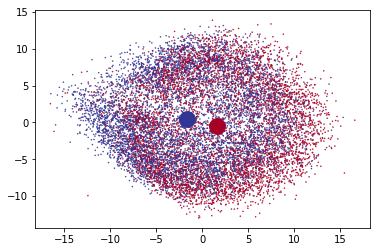

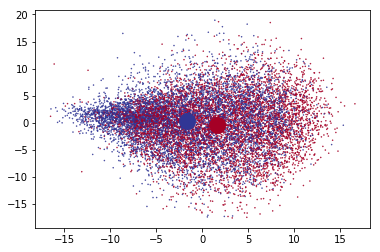

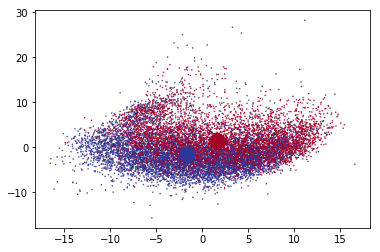

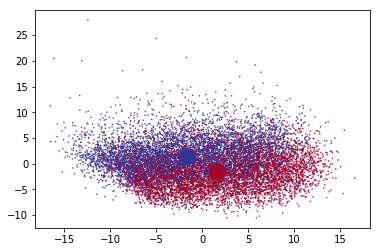

In [110]:
comp1 = 0
for comp2 in [1, 2, 3, 4]:
    plt.scatter(XPCA[:, comp1], XPCA[:, comp2], s=1, marker='.', c=y, cmap=plt.cm.get_cmap('RdYlBu', 2))
    # plt.show()

    for label in np.unique(y):
        mask = y == label
        plt.scatter(XPCA[mask, comp1].mean(), XPCA[mask, comp2].mean(), s=1000, marker='.', c=cmap(np.array((label,))))
    plt.show()